# High Cardinality Text-based Categorical Variable Classification

# Introduction

This notebook was written to research a viable method to deal with text-based categorical features with high cardinality - e.g. from our test/train split, <b>installer</b> has 2146 unique categories in the training data set.  For tree-based models, this rules out the use of One-Hot Encoding, since doing so on will render not only GridSearch intractible, but also relegates building the model itself to a very long time.  Additionally, it has been show that better models can be built using, for example, Label or Target/Mean Encoding.

So, we accept this as a base premise - that we will use techniques that capture the basic idea behind Label Encoding.  Our ultimate goal is to boost predictive accuracy - i.e. to build the best model - as possible.

Having said that, in line with this goal, inspecting the space of categories in, for example, <b>installer</b> shows that there are many categories that appear to duplicate one another that may only differ by whitespace, case (upper/lower), misspellings, and even word-omission.  Thus, these so-called "unique" categories are not truly unique since their "meaning" has been duplicated but represented in slightly different values.  This is rather easy for a human being to detect.  But out of the box, without additional processing, each category taken as is will be considered unique unto itself.  Finally, by implementing some Natural Language analysis and techniques, we can deal with such errors in order to correct for a better predictive accuracy.

The specific techniques we explore in developing such a preprocessing procedure are <code>TF-IDF</code> combined with <code>KMeans</code> Clustering.

In developing an "algorithm" for this sort of preprocessing, we will use the <b>installer</b> categorical variable from our training data set but the intent is to develop a procedure that can be applied to any categorical variable meeting the criteria above.

<p><br>
<h1>Plan of Attack: Use TF-IDF to reduce similar <i>installer</i> categories to their truly unique representation</h1>

This must be done since there are MANY categories in, for example, <b>installer</b> AND there may be many categories that differ by:
<ol>
    <li>case (upper-lower)</li>
    <li>whitespace</li>
    <li>spelling errors</li>
    <li>word ommission</li>
</ol>

<h3>High-level Overview of <i>The Plan</i></h3>
<ol>
    <li>Use TF-IDF to vectorize corpus of DIRTY <b>installer</b> categories
        <ol>
            <li>create CORPUS of DIRTY <b>installer</b>s</li>
            <li>TF-IDF will first preprocess corpus by, for each <b>installer</b>:
                <ol>
                    <li>Tokenizing all words</li>
                    <li>convert words to lowercase</li>
                    <li>filter (remove) stop words e.g. "the", "and", "a", etc.</li>
                    <li>filter (remove) single-letter words</li>
                </ol>
            </li>
            <li>TF-IDF fits and creates a <b>vocabulary</b> after the above preprocessing, where:
                <ol>
                    <li>each "document" (<b>installer</b>) consists of a <b>vector</b></li>
                    <li>in each of these vectors, a component of the vector corresponds to a word in the <b>vocabulary</b> - thus, all vectors have the same number of dimensions, corresponding to the size of the <b>vocabulary</b>
                    <li>the value of each component is the <b>Inverse Document Frequency</b> of the corresponding word (should it occur in the document (<b>installer</b>))</li>
                </ol>
            </li>
        </ol>              
    </li>
    <li>Use <code>KMeans</code> to create clusters of size <code>n_target_cluster_size</code> (hyper-parameter) from the space of TF-IDF vectors created from the <b>corpus</b></li>
    <li>Use the <code>centroid</code> (a TF-IDF vector) of each of the <code>K-Means</code> clusters as the "master" for that category of <b>installer</b></li>
    <li>Replace all category values in a cluster with the corresponding "master"</li>
</ol>

In [38]:
import pandas as pd
from scjpnlib.utils.file_io import FileManager
from IPython.core.display import HTML, Markdown
import scjpnlib.utils as scjpnutils
import numpy as np
import matplotlib.pyplot as plt
from scjpnlib.utils.skl_transformers import SimpleValueTransformer

from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.stats import entropy
import math
from sklearn.cluster import KMeans
from scjpnlib.utils import submodels as scjpnsubmodels


%load_ext autoreload
%autoreload 2

pd.set_option('display.max_rows', 50)
pd.set_option('display.min_rows', 50)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Implementation

## Read Config for this Experiment

The following reads properties from the `experiment-config.txt` file as JSON.  (see the `experiment-config.txt` file for documentation on different experiment configs)

In [2]:
fm = FileManager()
eda_config = fm.load_json('eda-config.txt')
eda_config

{'official_data': {'unlabeled_predictors': {'url': 'https://s3.amazonaws.com/drivendata-prod/data/7/public/702ddfc5-68cd-4d1d-a0de-f5f566f76d91.csv',
   'local_fname': 'Taarifa-Unlabeled-Predictors.csv'},
  'labeled_predictors': {'url': 'https://s3.amazonaws.com/drivendata-prod/data/7/public/4910797b-ee55-40a7-8668-10efd5c1b960.csv',
   'local_fname': 'Taarifa-Labeled-Predictors.csv'},
  'labels': {'url': 'https://s3.amazonaws.com/drivendata-prod/data/7/public/0bf8bc6e-30d0-4c50-956a-603fc693d966.csv',
   'local_fname': 'Taarifa-Labels.csv'}},
 'eda_desc': {'short': '0.10 test_ratio, flat insig cat hat handling with threshold 10; location based on ward'},
 'test_ratio': 0.1,
 'SEED': 42,
 'insig_cat_handling': {'installer': {'strategy': 'flat',
   'threshold': 10,
   'map_to': 'other'},
  'scheme_name': {'strategy': 'flat', 'threshold': 10, 'map_to': 'other'},
  'ward': {'strategy': 'flat', 'threshold': 10, 'map_to': 'other'}},
 'wrangled_data': {'fname_ext': 'csv',
  'train': {'fname_

In [3]:
display(HTML(f"<b>NOTE: <i>for the above experiement configuration, wrangled and partitioned label files will be identified (filename suffix) by: hash digest: {scjpnutils.json_to_md5_hash_digest(eda_config)}</i></b>"))

In [4]:
fname_unlabeled_predictors = eda_config['official_data']['unlabeled_predictors']['local_fname']
fname_labeled_predictors = eda_config['official_data']['labeled_predictors']['local_fname']
fname_labels = eda_config['official_data']['labels']['local_fname']

ds_map = {
    fname_unlabeled_predictors: eda_config['official_data']['unlabeled_predictors']['url'], 
    fname_labeled_predictors: eda_config['official_data']['unlabeled_predictors']['url'],
    fname_labels: eda_config['official_data']['unlabeled_predictors']['url']
}

fm.validate_download(ds_map)

In [5]:
SEED = eda_config['SEED'] # for random_state reproducability

In [6]:
labels = pd.read_csv(fname_labels)
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            59400 non-null  int64 
 1   status_group  59400 non-null  object
dtypes: int64(1), object(1)
memory usage: 928.2+ KB


In [7]:
classes = labels.status_group.unique()

In [8]:
X_unlabeled = pd.read_csv(fname_unlabeled_predictors)

X_labeled = pd.read_csv(fname_labeled_predictors)
X_labeled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

<p><br>
<h1><i>installer</i> Classification</h1>

In [9]:
scjpnutils.analyze_values(X_labeled[['installer']], 'X_labeled <i>installer</i>');

,feature,dtype,n_unique,unique_vals,n_unique_ratio,p_cat,n_null,n_null_ratio,null_index
0,installer,object,2146,"[Roman, GRUMETI, World vision, UNICEF, Artisan...",0.036128,96.39,3655,0.061532,"Int64Index([ 34, 43, 47, 65, 71,..."


<h2>First replace null/missing values</h2>
None of this can be done until we first execute this.

In [10]:
replace_null_rules = {}
replace_null_rules['installer'] = [
    {
        'missing_values': np.nan,
        'strategy': 'constant', 
        'fill_value': 'None'
    }
]
svt_null_predictors = SimpleValueTransformer(replace_null_rules)
X_labeled_installer_clean = svt_null_predictors.fit_transform(X_labeled)[['installer']].copy()

<p><br>
<h2>Create <i>installer</i> corpus and fit it with <code>TF-IDF</code></h2>

<h3>Pre-processing Semantics: convert to lower-case, tokenize, remove stop-words, etc.</h3>

In [11]:
scjpnutils.display_sourcecode(scjpnsubmodels.preprocess__lcase_strip)
scjpnutils.display_sourcecode(scjpnsubmodels.preprocess__tokenize)
scjpnutils.display_sourcecode(scjpnsubmodels.get_stopwords)
scjpnutils.display_sourcecode(scjpnsubmodels.preprocess__filter_stopwords)
scjpnutils.display_sourcecode(scjpnsubmodels.preprocess_all)

<h3>Fit <code>TF-IDF</code> to the corpus</h3>

In [12]:
# note that we use the raw (un-preprocessed) feature since we pass in the preprocessor (preprocess_all) to the TfidfVectorizer
corpus = list(X_labeled_installer_clean.installer.unique())

tfidf_vectorizer = TfidfVectorizer(preprocessor=scjpnsubmodels.preprocess_all)
tfidf = tfidf_vectorizer.fit_transform(corpus)

print(f"there are {len(tfidf_vectorizer.vocabulary_)} words in the vocabulary after fitting corpus to TF-IDF model")

there are 1883 words in the vocabulary after fitting corpus to TF-IDF model


<h3>Utility Functions used to Manipulate the TF-IDF model - e.g. to fit a document (<i>installer</i>) instance</h3>

We will use these to relate DIRTY categories to their pre-processed (cleaned) counterparts within the <code>TF-IDF</code> model

In [13]:
scjpnutils.display_sourcecode(scjpnsubmodels.tfidf_vocab_to_idx_map)
scjpnutils.display_sourcecode(scjpnsubmodels.tfidf_vec_to_doc)
scjpnutils.display_sourcecode(scjpnsubmodels.doc_to_tfidf_fit)

<h3>Usage Example</h3>

In order to demonstrate their usage, let's first conduct a search of some <b>installer</b> categories that are not <i>alphanumeric</i>.  Note that, by definition, this subset will implicitly include those categories of <b>installer</b> with whitespace.

<h4>"Helper" code to set up example - observing the "evolution"</h4>

We will first add some columns to show the evolution of a category from DIRTY to CLEAN (after fitting the corpus the TF-IDF model).

In [14]:
# add the result of the first step of preprocessing: coverting to lower-case
X_labeled_installer_clean['installer_stripped_lcase'] = X_labeled_installer_clean.installer.apply(scjpnsubmodels.preprocess__lcase_strip)

# add the result of the next step of preprocessing: tokenization
X_labeled_installer_clean['installer_word_tokenized'] = X_labeled_installer_clean.installer_stripped_lcase.apply(scjpnsubmodels.preprocess__tokenize)

# add the result of the next step of preprocessing: remove stop-words
X_labeled_installer_clean['installer_word_tokenized_no_stopwords'] = X_labeled_installer_clean.installer_word_tokenized.apply(
    lambda installer_tokenized: scjpnsubmodels.preprocess__filter_stopwords(installer_tokenized, is_list=True)[0]
)

# do this beforehand to avoid recomputing it every time, should we pass in more than one document (installer)... which we do below
idx_term_map = scjpnsubmodels.tfidf_vocab_to_idx_map(tfidf_vectorizer.vocabulary_)

X_labeled_installer_clean['installer_after_tfidf'] = X_labeled_installer_clean.installer.apply(
    lambda installer: scjpnsubmodels.doc_to_tfidf_fit(installer, tfidf_vectorizer, idx_term_map)[0][0]
)

<h5>Let's have a look at the first few observations with these added columns</h5>

In [15]:
X_labeled_installer_clean.head(10)

,installer,installer_stripped_lcase,installer_word_tokenized,installer_word_tokenized_no_stopwords,installer_after_tfidf
0,Roman,roman,[roman],[roman],roman
1,GRUMETI,grumeti,[grumeti],[grumeti],grumeti
2,World vision,world vision,"[world, vision]","[world, vision]",vision world
3,UNICEF,unicef,[unicef],[unicef],unicef
4,Artisan,artisan,[artisan],[artisan],artisan
5,DWE,dwe,[dwe],[dwe],dwe
6,DWSP,dwsp,[dwsp],[dwsp],dwsp
7,DWE,dwe,[dwe],[dwe],dwe
8,Water Aid,water aid,"[water, aid]","[water, aid]",aid water
9,Artisan,artisan,[artisan],[artisan],artisan


The above is not very interesting since we can't see the transformation of particularly dirty categories in this subset.  In order to do so, we will subset to non-alphanumeric dirty categories of <b>installer</b>.

One thing to note is that the order of the words in the <code>installer_after_tfidf</code> feature has changed!  This is due to the <b>Inverse Document Frequency</b> result applied by the <code>TF-IDF</code> model: <i>the words in the mapped (cleaned) document are ordered by "<u>importance</u>"</i> - e.g. the (dirty) "Water Aid" category maps to cleaned (by <code>TF-IDF</code>) category "aid water" since, apparently, the word "aid" is more important than "water" in the <code>TF-IDF</code> model.

Let's now look at more interesting results by finding dirty <b>installer</b>s with non-alphanumeric categories and then inspect their corresponding mappings in the <code>TF-IDF</code> model.

In [16]:
# now find all qualifying non-alphanumeric observations of installer
(
    str_feat_unique_nonalphanumeric_string_vals, 
    df_analysis
) = scjpnutils.analyze_non_alphanumeric_strings(X_labeled[['installer']], 'X_labeled')

# store the index of qualifying observations so we can inspect the before/after results
non_alphanumeric_index = df_analysis[df_analysis.feature=='installer'].non_alphanumeric_str_index.values[0]

,feature,n_unique,n_non_alphanumeric_str,non_alphanumeric_str_index
0,installer,2146,9584,"Int64Index([ 2, 8, 12, 13, 26,..."


<h5>Let's focus on a few interesting non-alphanmeric categories: "Adra /Community", "Adra/ Community", and "Adra/Community"</h5>

Note the whitespace and "/" placement in these examples.  Without <code>TF-IDF</code>, each of these is considered unique!

In [17]:
dirty_category = 'Adra /Community'
fitted_doc = scjpnsubmodels.doc_to_tfidf_fit(dirty_category, tfidf_vectorizer, idx_term_map)
print(f"DIRTY category-value '{dirty_category}' maps to '{fitted_doc[0][0]}' in the TD-IDF model")

dirty_category = 'Adra/ Community'
fitted_doc = scjpnsubmodels.doc_to_tfidf_fit(dirty_category, tfidf_vectorizer, idx_term_map)
print(f"DIRTY category-value '{dirty_category}' maps to '{fitted_doc[0][0]}' in the TD-IDF model")

dirty_category = 'Adra/Community'
fitted_doc = scjpnsubmodels.doc_to_tfidf_fit(dirty_category, tfidf_vectorizer, idx_term_map)
fitted_doc
print(f"DIRTY category-value '{dirty_category}' maps to '{fitted_doc[0][0]}' in the TD-IDF model")

DIRTY category-value 'Adra /Community' maps to 'adra community' in the TD-IDF model
DIRTY category-value 'Adra/ Community' maps to 'adra community' in the TD-IDF model
DIRTY category-value 'Adra/Community' maps to 'adra community' in the TD-IDF model


<h5>Now let's demonstrate why wording is re-ordered by <code>TF-IDF</code></h5>

For this, we will use dirty categories "World vision" and "Water Aid", for demonstration, which map to "vision world" and "aid water", respectively, in the <code>TF-IDF</code> model.

In [18]:
dirty_category = 'World vision'
fitted_doc = scjpnsubmodels.doc_to_tfidf_fit(dirty_category, tfidf_vectorizer, idx_term_map)
print(fitted_doc)

dirty_category = 'Water Aid'
fitted_doc = scjpnsubmodels.doc_to_tfidf_fit(dirty_category, tfidf_vectorizer, idx_term_map)
print(fitted_doc)

(('vision world', [('vision', 0.7624555241955246), ('world', 0.6470406274908304)]), array([0., 0., 0., ..., 0., 0., 0.]))
(('aid water', [('aid', 0.8157909307194062), ('water', 0.5783469178235197)]), array([0., 0., 0., ..., 0., 0., 0.]))


This shows (maybe not entirely) clearly that in the "World vision" dirty category case, the `TF-IDF` model assigns <b>IDF</b> (<b>Inverse Document Frequency</b> - i.e. importance) values of `0.7624555241955246` to "vision" and `0.6470406274908304` to "world", and `0.8157909307194062` to "aid" and `0.5783469178235197` to "water" in the "Water Aid" case.

<h5>Example Wrap-up: inspecting <code>TF-IDF</code> mappings of dirty, non-alphanumeric <u>installer</u> categories</h5>

In [19]:
X_labeled_installer_clean__nonalphanumeric = X_labeled_installer_clean.loc[non_alphanumeric_index]
X_labeled_installer_clean__nonalphanumeric

,installer,installer_stripped_lcase,installer_word_tokenized,installer_word_tokenized_no_stopwords,installer_after_tfidf
2,World vision,world vision,"[world, vision]","[world, vision]",vision world
8,Water Aid,water aid,"[water, aid]","[water, aid]",aid water
12,World vision,world vision,"[world, vision]","[world, vision]",vision world
13,Lawatefuka water sup,lawatefuka water sup,"[lawatefuka, water, sup]","[lawatefuka, water, sup]",lawatefuka sup water
26,Kilolo Star,kilolo star,"[kilolo, star]","[kilolo, star]",kilolo star
28,District council,district council,"[district, council]","[district, council]",council district
29,Lawatefuka water sup,lawatefuka water sup,"[lawatefuka, water, sup]","[lawatefuka, water, sup]",lawatefuka sup water
35,Not known,not known,"[not, known]","[not, known]",known not
36,Central government,central government,"[central, government]","[central, government]",central government
45,World Vision,world vision,"[world, vision]","[world, vision]",vision world


There is not much to say here other than to point out mappings of a few additional particularly interesting dirty categories:
<ul>
    <li>dirty category "<b>KKKT _ Konde and DWE</b>" maps to "<b>dwe kkkt konde</b>" <code>TF-IDF</code> cleaned category</li>
    <li>dirty category "<b>District Council</b>" and "<b>DISTRICT COUNCIL</b>" (and other variants with that spelling) both map to "<b>council district</b>" <code>TF-IDF</code> cleaned category, while:
        <ul>
            <li>"<b>District counci</b>" maps to "<b>counci district</b>" <code>TF-IDF</code> cleaned category - note the ommission of the "l"</li>
        </ul>
    </li>
</ul>

In the first case, we see that stop words and weird punctuation are nicely cleaned by `TF-IDF`.

In the latter case, there is not much else to be done with overt spelling errors, without implementing much more sophisticated spelling-error correction techniques.  We could spend the time to meticulously go over these results and fix them by hand but doing such would tailor the end result toward the training dataset if we inject too much "human knowledge" into the machine learning process.

Let's see compare the count of unique DIRTY <b>installer</b> categories to the count of corresponding <code>TF-IDF</code> cleaned categories.

In [20]:
len(X_labeled_installer_clean.installer.unique())

2146

In [21]:
len(X_labeled_installer_clean.installer_after_tfidf.unique())

1808

We could, in theory label-encode the <code>TF-IDF</code> cleaned categories and create a tree-based model to predict pump failure.  But let's first leverage the <code>TF-IDF</code> we created in a <code>KMeans</code> model to for a further SUBSTANTIAL reduction.  The idea is to classify categories by similarity according to the <code>TF-IDF</code> model, wherein similar categories should belong to the same cluster.  The trick will be to find the best granularity (read: cluster-size) to get high enough resolution while garnoring a decent reduction - remember, we started from 2146 unique dirty categories of <b>installer</b>.  Also note that <b><code>KMeans</code> Clustering can also handle misspellings whereas <code>TF-IDF</code> <i>alone</i> cannot</b>.  Finally, we will apply the same preprocessing to other categorical variables that also have high cardinality in categories.

<p><br>
<h2>Create <code>KMeans</code> model using the <code>TF-IDF</code> model</h2>

The first thing to note here is that we will be using a "synthetic" hyper-parameter: <code>n_target_cluster_size</code>.  This hyper-parameter does exactly what its name suggests: tunes the target size we want for each cluster <code>KMeans</code> will create.  The details of the search for tuning this hyper-parameter have been ommitted, but for this study the optimal result is <code>n_target_cluster_size=10</code>.

In [22]:
dist_normalized = X_labeled_installer_clean.installer_after_tfidf.value_counts(normalize=True)
dist_normalized

dwe                           0.293367
none                          0.061532
government                    0.031835
hesawa                        0.023485
                              0.023148
rwe                           0.020303
commu                         0.017929
danida                        0.017677
council district              0.016246
kkkt                          0.015320
central government            0.012845
tcrs                          0.011919
vision world                  0.011768
danid                         0.010505
ces                           0.010269
community                     0.009343
gover                         0.008603
amref                         0.007458
tasaf                         0.007020
lga                           0.006953
wedeco                        0.006700
fini water                    0.006549
dmdd                          0.006330
norad                         0.006162
twesa                         0.005320
                         

In [23]:
entropy(dist_normalized, base=2) # entropy is a measure of disorder and in information theory is basically equivalent to the "number of questions we need to ask to get the right answer" (given a probability distribution)

6.128975304278281

In [24]:
math.ceil(entropy(dist_normalized, base=2)) # so we will set n_target_cluster_size to this

7

In [25]:
# hyper-param
n_target_cluster_size = math.ceil(entropy(dist_normalized, base=2)) 

n_clusters = int(len(corpus)/n_target_cluster_size) # 8 is default but we want n_clusters to be related to entropy

Note: for explanation of why we use *entropy* (ceiling) as the target mean cluster size, see https://www.youtube.com/watch?v=2s3aJfRr9gE for a friendly explanation.

Building the <code>KMeans</code> model using the <code>TF-IDF</code> model is straightforward.

In [26]:
kmeans = KMeans(n_clusters=n_clusters).fit(tfidf)

display(HTML(f"this kmeans model has {len(kmeans.cluster_centers_)} clusters for <b>installer</b>"))

<b>Each cluster in `kmeans.cluster_centers_` is uniquely identified by its index, which can then be used to represent the dirty <i>installer</i> category</b>.

In [27]:
df_kmeans_clusters = scjpnsubmodels.kmeans_centroids_to_docs(kmeans, idx_term_map)
df_kmeans_clusters

,tfidf_vector,doc
centroid_idx,,
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",batist church
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",council district mbozi mbulu wb
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",dwe japani marekani ubalozi wa
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",department distric lindi region rural water
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",co jandu plumber
5,"[0.0008453085376162299, 0.0008453085376162299,...",aar aartisa abasia abd abdala abdalkah abdalla...
6,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",council villege
7,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",singasinga
8,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",atlas company


Now, we can look up the associated centroid by <code>TF-IDF</code> vector for a given dirty <b>installer</b> category.  Even if it is misspelled, by virtue of <code>TF-IDF</code> similarity and if we've hyper-tuned this submodel correctly, misspellings should belong to the same cluster (class) of <b>installer</b>.

Finally, <b>with this approach, we have reduced the total count of unique DIRTY <i>installer</i>s all the way from 2146 down to 214 very accurate class membership representations</b>.

Let's wrap this up by taking a look at a few examples.

In [28]:
scjpnutils.display_sourcecode(scjpnsubmodels.predict_kmeans_cluster_membership)

In [29]:
dirty_installer_samples = [
    'Adra /Community',
    'Adra /Community',
    'Adra/ Community',
    'World Vision',
    'MANYARA CONSTRUCTION'
]

for dirty_installer_sample in dirty_installer_samples:
    scjpnsubmodels.predict_kmeans_cluster_membership(
        dirty_installer_sample, 
        kmeans, 
        tfidf_vectorizer, 
        idx_term_map, 
        suppress_output=False
    );

Um... okay?!  What on Earth happened with the class indentified by <code>KMeans</code> centroid index predicted for DIRTY category 'MANYARA CONSTRUCTION'???  Let's inspect the <code>TF-IDF</code> vector for this class.

In [30]:
weird_cluster_idx = scjpnsubmodels.predict_kmeans_cluster_membership(
    'MANYARA CONSTRUCTION', 
    kmeans, 
    tfidf_vectorizer, 
    idx_term_map, 
    suppress_output=True
)[0]
weird_cluster_tfdidf_vector = df_kmeans_clusters.iloc[weird_cluster_idx].tfidf_vector
weird_cluster_tfdidf_vector

array([0.00084531, 0.00084531, 0.00084531, ..., 0.00084531, 0.        ,
       0.00059772])

In [31]:
weird_cluster_tfdidf_vector.max()

0.006452226689647709

Ahhh... so <code>KMeans</code> was smart enough to group all <i>low-importance</i> (low <b>Inverse Document Frequency</b>) terms together in a single class.  <u>We should then expect these to correspond to HIGH-occurrence DIRTY <b>installer</b> categories</u>.  So <b>observations containing <i>installer</i> belonging to this class should have a HIGH impact on the model predicting pump failure in the end - this is why they can be effectively grouped together while still maintaining high predictive power</b>.

Now we move on to add the new feature, <b>installer_class</b>.

<p><br>
<h2>Add new feature: <i>installer_class</i></h2>

This is very straightforward.  <b>We simply set <b>installer_class</b> to the correspondinng <code>KMeans</code> Cluster index</b>.

In [32]:
X_labeled_installer_clean['installer_class'] = X_labeled_installer_clean.installer.map(
    lambda installer: scjpnsubmodels.predict_kmeans_cluster_membership(
        installer, 
        kmeans, 
        tfidf_vectorizer, 
        idx_term_map, 
        suppress_output=True
    )[0]
)

To wrap this up, let's have a look at the new feature in the data set.

In [33]:
X_labeled_installer_clean = X_labeled_installer_clean.drop(
    [
        'installer_stripped_lcase',
        'installer_word_tokenized',
        'installer_word_tokenized_no_stopwords',
        'installer_after_tfidf'
    ], 
    axis=1
)
X_labeled_installer_clean

,installer,installer_class
0,Roman,66
1,GRUMETI,5
2,World vision,204
3,UNICEF,264
4,Artisan,5
5,DWE,63
6,DWSP,5
7,DWE,63
8,Water Aid,104
9,Artisan,5


Let's have a look at the distribution of the new <b>installer_class</b> feature.

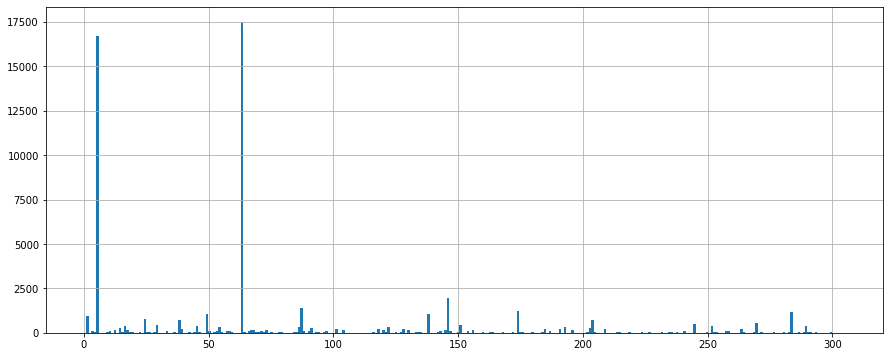

In [39]:
plt.figure(figsize=(15,6))
X_labeled_installer_clean.installer_class.hist(bins=len(df_kmeans_clusters))

In [35]:
df_kmeans_clusters['frequency'] = df_kmeans_clusters.reset_index().centroid_idx.apply(
    lambda centroid_idx: X_labeled_installer_clean.installer_class.value_counts()[centroid_idx]
)
df_kmeans_clusters.sort_values(by='frequency', ascending=False)

,tfidf_vector,doc,frequency
centroid_idx,,,
63,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",dwe lwi rwe tcrs,17481
5,"[0.0008453085376162299, 0.0008453085376162299,...",aar aartisa abasia abd abdala abdalkah abdalla...,16707
146,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",belgiam cebtral cental community finland gover...,1933
87,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",hesawa,1395
174,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",community rwe tcrs,1238
284,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",church dioces dme dwe juu katiti kkkt konde le...,1161
49,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",commu,1065
138,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",co danida,1051
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",council district mbozi mbulu wb,972


The above algorithm has been wrapped up in one function, `tfidf_kmeans_classify_feature`, so that it may be cleanly and easily deployed.

The source code is as follows:

In [36]:
scjpnutils.display_sourcecode(scjpnsubmodels.tfidf_kmeans_classify_feature)

As the last example, let's now use this to classify <b>scheme_name</b> - another high-cardinality categorical variable in the same data set.

<p><br>
<h1><i>scheme_name</i> Classification (using the <code>tfidf_kmeans_classify_feature</code> function)</h1>

,scheme_name,scheme_name_stripped_lcase,scheme_name_word_tokenized,scheme_name_word_tokenized_no_stopwords,scheme_name_after_tfidf
0,Roman,roman,[roman],[roman],roman
1,None,none,[none],[none],none
2,Nyumba ya mungu pipe scheme,nyumba ya mungu pipe scheme,"[nyumba, ya, mungu, pipe, scheme]","[nyumba, ya, mungu, pipe, scheme]",mungu nyumba pipe scheme ya
3,None,none,[none],[none],none
4,None,none,[none],[none],none
5,Zingibali,zingibali,[zingibali],[zingibali],zingibali
6,None,none,[none],[none],none
7,None,none,[none],[none],none
8,None,none,[none],[none],none
9,None,none,[none],[none],none


,scheme_name,scheme_name_class
0,Roman,381
1,None,383
2,Nyumba ya mungu pipe scheme,393
3,None,383
4,None,383
5,Zingibali,11
6,None,383
7,None,383
8,None,383
9,None,383


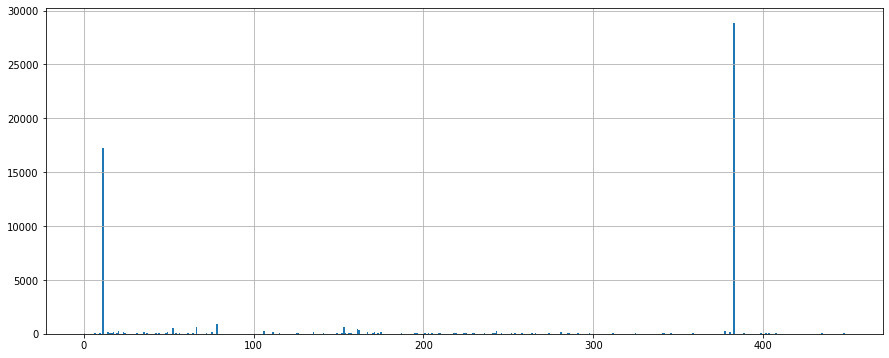

,tfidf_vector,doc,frequency
centroid_idx,,,
383,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",none,28835
11,"[0.0, 0.0, 0.00036084391824351607, 0.0, 0.0, 0...",african akheri aleni alpha amref amrsf anglic ...,17258
78,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",chela ctu ekenywa estate flowers iboja ii kira...,905
66,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",borehole drilling gen government jaira koronan...,640
153,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",bangwe bomba bombambil buhanda businde chemche...,620
52,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",gravity ombe scheme supply wanging water,509
161,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",chalinze wate,406
162,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",mkongoro one project two water,309
243,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",bagamoyo wate,296


In [42]:
scjpnsubmodels.tfidf_kmeans_classify_feature(X_labeled, 'X_labeled', 'scheme_name', verbose=1);

<p><br><br><br>

# Conclusion

That about wraps it up.